In [1]:
import os
import torch
from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bertviz import head_view, model_view
from sklearn.utils.class_weight import compute_class_weight

In [2]:
is_phonetic = False

paths = [
    '/home/toure215/BERT_phonetic/DATASETS/verses/verses_hf',
    '/home/toure215/BERT_phonetic/DATASETS/verses/phonetic_verses_hf'
]

models = [
    'bert-base-uncased',
    "psktoure/BERT_BPE_phonetic_wikitext-103-raw-v1",
]

In [3]:
idx = 0
if is_phonetic:
    idx = 1

In [4]:
dataset = load_from_disk(paths[idx])
dataset

DatasetDict({
    train: Dataset({
        features: ['Verse', 'label'],
        num_rows: 161190
    })
    test: Dataset({
        features: ['Verse', 'label'],
        num_rows: 19901
    })
    validation: Dataset({
        features: ['Verse', 'label'],
        num_rows: 17911
    })
})

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(
    models[idx],
    num_labels=4,
    ignore_mismatched_sizes=True,
    output_attentions=True,
    output_hidden_states=True,
    attn_implementation="eager",
)
tokenizer = AutoTokenizer.from_pretrained(models[idx])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/toure215/miniconda3/envs/bert/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.y_train = self.train_dataset["label"]

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        weight = torch.tensor(
            compute_class_weight(
                class_weight="balanced",
                classes=np.unique(self.y_train),
                y=self.y_train,
            ),
            device=self.args.device,
            dtype=torch.float,
        )
        loss_fct = torch.nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [7]:
def tokenize_function(examples):
    return tokenizer(
        examples["Verse"], padding=False, truncation=True, max_length=256
    )


encoded_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["Verse"],
    num_proc=os.cpu_count() - 1,
)

data_collator = DataCollatorWithPadding(tokenizer)

In [8]:
training_args = TrainingArguments(
    output_dir="/tmp/rhyme_bert",
    num_train_epochs=3,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    eval_strategy="epoch",
    logging_strategy="no",
    save_strategy="no",
    report_to="none",
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    data_collator=data_collator,
)

/home/toure215/miniconda3/envs/bert/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [9]:
trainer.train()

  0%|          | 0/1890 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

{'eval_loss': 0.17306402325630188, 'eval_runtime': 1.3372, 'eval_samples_per_second': 13394.679, 'eval_steps_per_second': 52.349, 'epoch': 1.0}


  0%|          | 0/70 [00:00<?, ?it/s]

{'eval_loss': 0.15092453360557556, 'eval_runtime': 1.3346, 'eval_samples_per_second': 13420.132, 'eval_steps_per_second': 52.449, 'epoch': 2.0}


  0%|          | 0/70 [00:00<?, ?it/s]

{'eval_loss': 0.1625901609659195, 'eval_runtime': 1.3282, 'eval_samples_per_second': 13485.302, 'eval_steps_per_second': 52.703, 'epoch': 3.0}
{'train_runtime': 103.885, 'train_samples_per_second': 4654.857, 'train_steps_per_second': 18.193, 'train_loss': 0.14860901201843585, 'epoch': 3.0}


TrainOutput(global_step=1890, training_loss=0.14860901201843585, metrics={'train_runtime': 103.885, 'train_samples_per_second': 4654.857, 'train_steps_per_second': 18.193, 'total_flos': 4697169628970208.0, 'train_loss': 0.14860901201843585, 'epoch': 3.0})

In [10]:
# predictions = trainer.predict(encoded_dataset["test"])
# preds, labels = predictions.predictions, predictions.label_ids
# preds = np.argmax(preds, axis=1)

In [11]:
# print(np.where(preds == labels, 1, 0))

In [12]:
verse = dataset["test"][3]["Verse"]
print("verse: ", verse, "\nlabel: ", dataset["test"][3]["label"])
inputs = tokenizer(verse, return_tensors="pt", padding=True, truncation=True, max_length=256)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

outputs = model(**inputs)
print("prediction:", outputs.logits.argmax(-1).item())
attentions = outputs.attentions

print(attentions[0].shape)

verse:  where trees in regular confusion stand 
label:  0
prediction: 0
torch.Size([1, 12, 8, 8])


In [13]:
layer = -1
head = 0

attention_scores = attentions[layer][0][head].cpu().detach().numpy()

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
print(tokens)

['[CLS]', 'where', 'trees', 'in', 'regular', 'confusion', 'stand', '[SEP]']


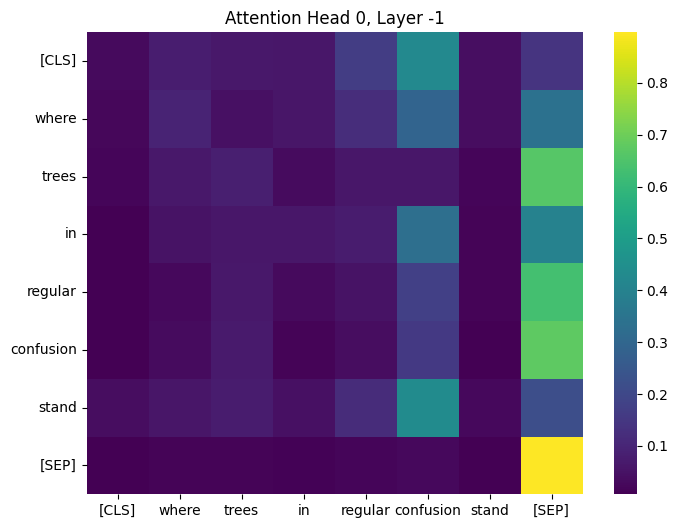

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(attention_scores, xticklabels=tokens, yticklabels=tokens, cmap="viridis")
plt.title(f"Attention Head {head}, Layer {layer}")
plt.show()

In [15]:
head_view(attentions, tokens)

<IPython.core.display.Javascript object>

In [16]:
model_view(attentions, tokens)

<IPython.core.display.Javascript object>

In [17]:
verses = []
for idx, verse in enumerate(dataset["test"]):
    inputs = tokenizer(verse["Verse"], return_tensors="pt", padding=True, truncation=True, max_length=256, add_special_tokens=False)
    verse_split = verse["Verse"].split()
    if len(inputs["input_ids"][0]) == len(verse_split):
        verses.append(idx)

print(len(verses))

5440


In [18]:
idx = verses[0]
print(idx)
verse = dataset["test"][idx]["Verse"]
print("verse: ", verse, "\nlabel: ", dataset["test"][3]["label"])
inputs = tokenizer(verse, return_tensors="pt", padding=True, truncation=True, max_length=256)
inputs = {k: v.to(model.device) for k, v in inputs.items()}

embeddings = model.get_input_embeddings()
word_embeddings = embeddings(inputs["input_ids"])
print(word_embeddings.shape)

3
verse:  where trees in regular confusion stand 
label:  0
torch.Size([1, 8, 768])


In [19]:
word_embeddings.retain_grad()

outputs = model(inputs_embeds=word_embeddings)

loss = outputs.logits.sum()
loss.backward()

grads = word_embeddings.grad
avg_grads = grads.abs().mean(dim=-1).squeeze().detach().cpu().numpy()

In [20]:
idx_to_label = {0: 'iambic', 1: 'anapaestic', 2: 'trochaic', 3: 'dactyl'}

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
label = dataset["test"][idx]["label"]
pred = outputs.logits.argmax(-1).item()
pred = idx_to_label[pred]
label = idx_to_label[label]
print("tokens:", tokens)
print("label:", label, "-- prediction:", pred)

tokens: ['[CLS]', 'where', 'trees', 'in', 'regular', 'confusion', 'stand', '[SEP]']
label: iambic -- prediction: iambic


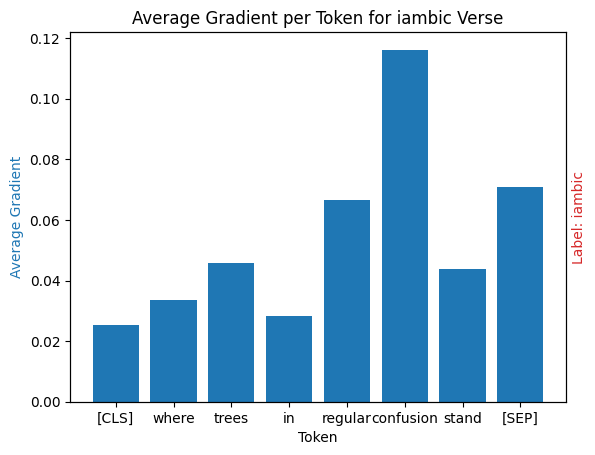

In [21]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.bar(tokens, avg_grads, color="tab:blue", align="center")
ax1.set_xlabel("Token")
ax1.set_ylabel("Average Gradient", color="tab:blue")
ax2.set_ylabel(f"Label: {label}", color="tab:red")
ax2.set_yticks([])
plt.title(f"Average Gradient per Token for {label} Verse")
plt.show()
